# It's 

In [442]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:.4f}'.format #set it to convert scientific noations such as 4.225108e+11 to 422510842796.00
pd.set_option('display.max_columns', 100) #  display all the columns
pd.set_option('display.max_rows', 100) # display all the rows
np.set_printoptions(suppress=True,formatter={'float_kind':'{:f}'.format})

%matplotlib inline

In [379]:
# importing the data

df = pd.read_csv('2nd_clean.csv')
original_df = df.copy()
df.drop('Unnamed: 0',axis='columns',inplace=True)

In [380]:
df = df.rename(columns={"loan_amnt": "loan_amount", "funded_amnt": "funded_amount", "funded_amnt_inv": "investor_funds",
                       "int_rate": "interest_rate", "annual_inc": "annual_income"})

In [662]:
purpose_df=pd.DataFrame(df['purpose'].value_counts(normalize=True)*100)

purpose_df.columns=['fraction']
purpose_df['purpose'] = purpose_df.index

In [ ]:
df['issue_d'] = pd.to_datetime(df['issue_d'])


by_year = df.groupby(by=df['issue_d'].dt.year)[['loan_status']].count()


ax = by_year.plot(figsize=(8,5))

by_year.plot(kind='bar',figsize=(20,8),ax = ax)
plt.title('Number of loans by year',fontsize=25)
plt.xlabel('Year',fontsize=25)
plt.ylabel('Number of loans',fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()


# Overview

* Lending club is a peer-to-peer lending platform headquatered in San-Francisco. It offers loans to the borrowers and investment opportunities to the peers willing to invest in a loan. More at - https://en.wikipedia.org/wiki/LendingClub

* The absolute majority of the loans is issued for debt-consolidation(56%). The next most common category is credit card (23%)

* The average size of a loan is USD 15000 while USD 40000 is the largest one recorded.

* The interest rate varies between 5.31% and 30.99% with the mean value of 16%.

* The number of loans has been rising since the date of inception in 2007 and reached 50000 mark in 2018. It is worth noting that the total number loans for every year includes roll-over loans issued before.

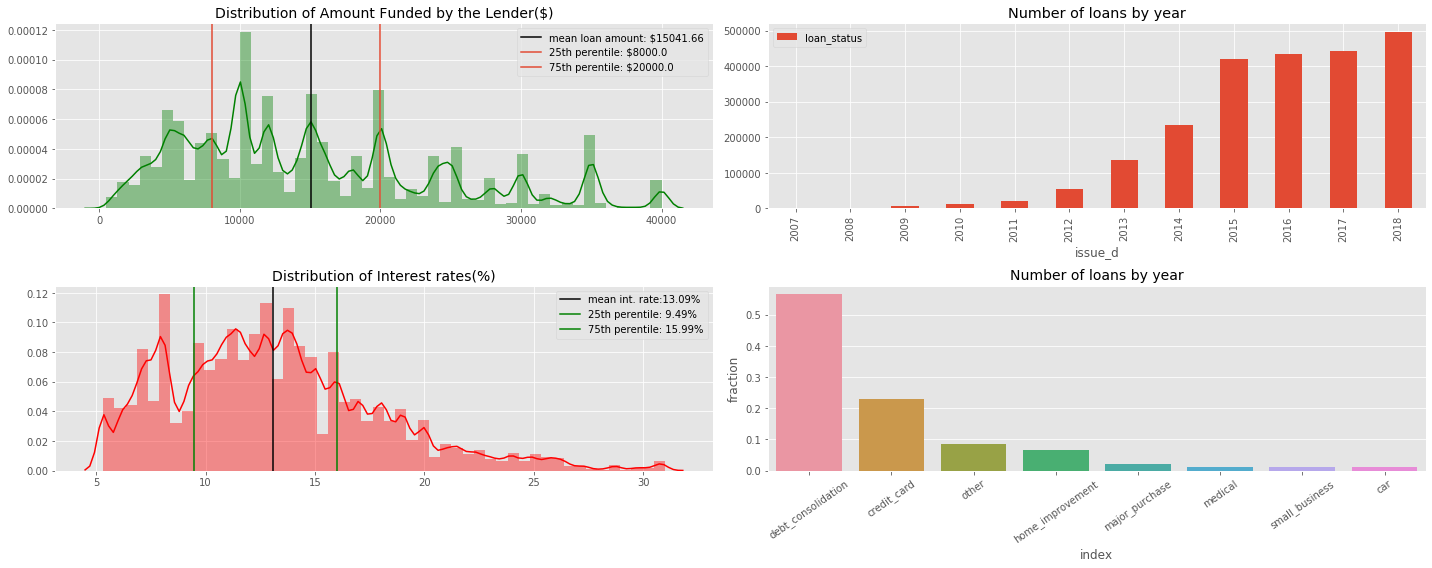

In [696]:
fig, ax = plt.subplots(2,2,figsize=(16,10),sharex=False, sharey=False)

funded_amount = df['funded_amount'].values
interest_rate = df['interest_rate'].values

sns.distplot(funded_amount, ax=ax[0,0], color="green")
ax[0,0].set_title("Distribution of Amount Funded by the Lender($)", fontsize=14)
ax[0,0].axvline(funded_amount.mean(),color='k',
             label='mean loan amount: ${}'.format(round(funded_amount.mean(),2)))
ax[0,0].axvline(np.percentile(funded_amount,[25]),
              label = "25th perentile: ${}".format(np.percentile(funded_amount,[25])[0],2))
ax[0,0].axvline(np.percentile(funded_amount,[75]),
             label = "75th perentile: ${}".format(np.percentile(funded_amount,[75])[0],2))
ax[0,0].legend()

sns.distplot(interest_rate, ax=ax[1,0], color="red")
ax[1,0].set_title("Distribution of Interest rates(%)", fontsize=14,)
ax[1,0].axvline(interest_rate.mean(),color='k',
              label='mean int. rate:{}%'.format(round(interest_rate.mean(),2)))
ax[1,0].axvline(np.percentile(interest_rate,[25]),
              label = "25th perentile: {}%".format(np.percentile(interest_rate,[25])[0],2),
             color='green')
ax[1,0].axvline(np.percentile(interest_rate,[75]),
             label = "75th perentile: {}%".format(np.percentile(interest_rate,[75])[0],2),
             color='green')
ax[1,0].legend()

sns.barplot(x='index',y='purpose',data=purpose,ax=ax[1,1])
ax[1,1].set_title("Fraction of loans by purpose", fontsize=14,)
plt.xticks(rotation=35)
plt.ylabel('fraction')

by_year.plot(kind='bar',figsize=(20,8),ax = ax[0,1], title='Number of loans by year')
plt.title('Number of loans by year',fontsize=14)

plt.tight_layout()

* Percantage change in total number of loans by year

In [383]:
by_year['pct_change'] = by_year.pct_change()*100
by_year.columns = ['loan counts','pct_change']
by_year

,loan counts,pct_change
issue_d,,
2007,603,NaN
2008,2393,296.849088
2009,5281,120.685332
2010,12537,137.398220
2011,21721,73.255165
2012,53367,145.693108
2013,134814,152.616786
2014,235629,74.780809
2015,421095,78.711025


# Is there a change in the fraction of bad loans?

The definition of bad loans is obviously somewhat arbitratry since "late loans" are included in the bad loan category. Grace Period loans are considered good loans in the following labeling.

As it can be seen from the graph the fraction of bad loans has been constantly decreasing since 2007(26.2%). In 2017 the fraction was 10.41%,
We can't take 2018 into account as the data for 2018 is not complete.

In [ ]:
bad_loan = ["Charged Off", "Default", 
            "Does not meet the credit policy. Status:Charged Off",
            "Late (16-30 days)", 
            "Late (31-120 days)"]

df['loan_condition'] = np.nan

def loan_condition(status):
    if status in bad_loan:
        return 'Bad Loan'
    else:
        return 'Good Loan'


df['loan_condition'] = df['loan_status'].apply(loan_condition)

In [63]:
pd.DataFrame(df["loan_status"].value_counts(normalize=True)*100)
# Fraction of loan status

,loan_status
Fully Paid,46.090448
Current,40.682444
Charged Off,11.574234
Late (31-120 days),0.968608
In Grace Period,0.395989
Late (16-30 days),0.165305
Does not meet the credit policy. Status:Fully Paid,0.087939
Does not meet the credit policy. Status:Charged Off,0.033663
Default,0.001371


In [686]:
#Butchering a dataframe to get fraction of bad loans breakdown

good_bad = df.groupby(by=[df['issue_d'].dt.year,'loan_condition']).count()
good_bad = good_bad.reset_index(level='loan_condition')
good_bad = good_bad[['loan_condition','loan_amount']]
good_bad.reset_index(inplace=True)
good_bad = good_bad.pivot_table(index='issue_d',columns='loan_condition')
good_bad.columns = good_bad.columns.droplevel()
good_bad.reset_index(inplace=True)
good_bad['ratio'] =  (good_bad['Bad Loan']/(good_bad['Good Loan']+good_bad['Bad Loan']))*100

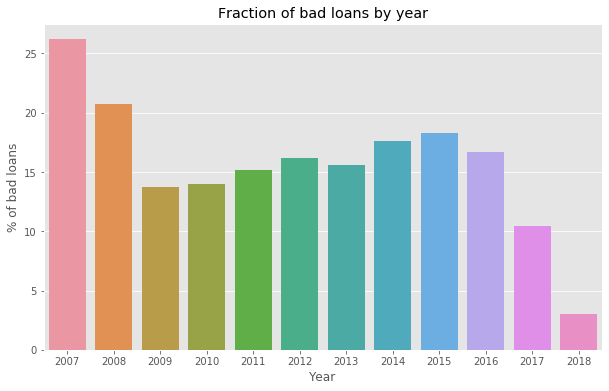

In [687]:
plt.style.use('ggplot')
plt.figure(figsize=(10,6))
sns.barplot(x="issue_d", y="ratio", data=good_bad)
plt.xlabel('Year')
plt.ylabel('% of bad loans')
plt.title('Fraction of bad loans by year')
plt.show()

# Are some regions better than other?

In [398]:
df['addr_state'].unique()

# Make a list with each of the regions by state.

west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']



df['region'] = np.nan

def finding_regions(state):
    if state in west:
        return 'West'
    elif state in south_west:
        return 'SouthWest'
    elif state in south_east:
        return 'SouthEast'
    elif state in mid_west:
        return 'MidWest'
    elif state in north_east:
        return 'NorthEast'
    
df['region'] = df['addr_state'].apply(finding_regions)

In [739]:
number_of_loans_by_region = df.groupby('region').count()[['loan_amount']]
average_int_rate_by_region = df.groupby('region').mean()['interest_rate']
average_annual_income_by_region = df.groupby('region').mean()['annual_income']
average_delinquency_by_region = df.groupby('region').mean()['acc_now_delinq']
average_loan_amount_by_region = df.groupby('region').mean()['loan_amount']

In [743]:
by_region = pd.concat([number_of_loans_by_region,
           average_loan_amount_by_region,
          average_int_rate_by_region,
          average_annual_income_by_region,
           average_delinquency_by_region
          ],axis=1)
by_region

,loan_amount,loan_amount,interest_rate,annual_income,acc_now_delinq
region,,,,,
MidWest,403150,14705.5851,13.0557,72646.0699,0.0040
NorthEast,519095,15185.0831,13.1015,82150.0402,0.0050
SouthEast,550165,14876.6191,13.2107,75036.6062,0.0039
SouthWest,272789,15400.3481,13.0192,79772.0676,0.0046
West,515469,15169.5212,13.0267,80199.9910,0.0035


In [748]:
#good_bad_loan_by_region = pd.crosstab(df['region'], df['loan_condition'])
#good_bad_loan_by_region['Bad Loan Fraction'] = good_bad_loan_by_region['Bad Loan']/(good_bad_loan_by_region['Bad Loan']+good_bad_loan_by_region['Good Loan']) 
good_bad_loan_by_region

loan_condition,Bad Loan,Good Loan,Bad Loan Fraction
region,,,
MidWest,49512,353638,0.1228
NorthEast,67337,451758,0.1297
SouthEast,72219,477946,0.1313
SouthWest,35173,237616,0.1289
West,63840,451629,0.1238
